In [1]:
# System imports
import re
import warnings

# Data science imports
import pandas as pd 
import numpy as np 

# Visualization imports
import matplotlib.pyplot as plt 
import seaborn as sns

# sklearn imports
import sklearn.model_selection 
import sklearn.linear_model
import sklearn.ensemble
import sklearn.svm
import sklearn.discriminant_analysis
import sklearn.metrics
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix, classification_report

# Tensorflow imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
import tensorflow.keras.backend as K

In [2]:
# Hide 'max_iter' warnings for logistic regression
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
# Helper class to train sklearn gridsearchcv models & report metrics
# Taken from: https://www.kaggle.com/anshumand0/anshuman-dewangan-ucsd-neural-data-challenge/notebook
class gridsearchcv_model:
#   model: saved model
#   name: name for model
#   train, val: object with {name, predictions, mse OR accuracy} 

    def __init__(self, model, X_train, Y_train, X_val, Y_val, parameter_matrix={}, is_classification=True, cv=4):
        self.is_classification = is_classification
        self.model = model
        self.train_model(self.model, X_train, Y_train, X_val, Y_val, parameter_matrix, cv)
        
    # Trains model using a training set and predicts a validation set
    def train_model(self, model, X_train, Y_train, X_val, Y_val, parameter_matrix={}, cv=4):
        if self.is_classification:
            ml_model = sklearn.model_selection.GridSearchCV(model, parameter_matrix, cv=cv, scoring='f1')
        
        ml_model.fit(X_train, Y_train)
        
        self.model = ml_model.best_estimator_
        self.name = re.compile("(.*?)\s*\(").match(str(self.model)).group(1)
        
        self.train = {'name': 'train'}
        self.val = {'name': 'val'}
        
        self.calculate_error(self.train, X_train, Y_train, self.train['name'])
        self.calculate_error(self.val, X_val, Y_val, self.val['name'])
        
        return ml_model
    
    def calculate_error(self, var, X_set, Y_set, name):
        var['name'] = name
        var['predictions'] = self.model.predict(X_set)
        var['accuracy'] = sklearn.metrics.f1_score(Y_set, var['predictions'])
        
        self.print_error(var)
        
    # Prints error metrics
    def print_error(self, var):
        print(self.name + ' ('+ var['name'] + ')')
        print("Accuracy: %0.4f" % var['accuracy'])

In [4]:
def plot_confusion_matrix(name, y_test, y_pred):
    label_mapping = {"Left":0, "Right": 1}
    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
    plt.xticks(np.arange(2) + 0.5, label_mapping.keys())
    plt.yticks(np.arange(2) + 0.5, label_mapping.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix of " + name)
    plt.show()

    print("Classification Report of %s:\n----------------------\n",name, clr)

### 1. Data extraction and preprocessing

In [5]:
# Load train and test data
data_path = "../input/ucsd-neural-data-challenge/data/"
df_train_original = pd.read_pickle(data_path + "epoched_train.pkl")

In [6]:
# Create column 'pid' which is the patient ID 1 through 9
df_train_original['pid'] = [int(df_train_original['patient_id'][x][2]) for x in range(len(df_train_original))]

# Create column 'trial_id' which is the trial 1 through 3
df_train_original['trial_id'] = [int(df_train_original['patient_id'][x][-2]) for x in range(len(df_train_original))]

In [7]:
# Use trials 1&2 for training, trial 3 for validation (mirrors process to create Kaggle test set)
df_train = df_train_original[df_train_original['trial_id']!=3]
df_train = df_train.reindex(np.random.permutation(df_train.index)).reset_index(drop=True)

df_test = df_train_original[df_train_original['trial_id']==3]
df_test = df_test.reindex(np.random.permutation(df_test.index)).reset_index(drop=True)

In [8]:
# data augmentation with gaussian noise
def data_augmentation(data):
    augmented = data.copy()
    for x in ['C3', 'Cz', 'C4', 'EOG:ch01', 'EOG:ch02','EOG:ch03']:
        augmented[x] += np.random.normal(0,1)
    return pd.concat([data, augmented])

def get_rid_of_items(data, item_list):
    return data.drop(item_list, axis = 1)

In [9]:
# data augmentation
df_train = data_augmentation(df_train)

# get rid of unrelated data
item_list = ["patient_id", "start_time", "event_type", "pid", "trial_id"]

y_train = df_train["event_type"].values.astype(float)
y_test = df_test["event_type"].values.astype(float)

X_train = get_rid_of_items(df_train, item_list)
X_test = get_rid_of_items(df_test, item_list)

In [10]:
# Concatenate the data for sklearn & neural net models
x_train_data = np.array(X_train.apply(lambda x:np.concatenate(x), axis=1).values.tolist())
x_test_data = np.array(X_test.apply(lambda x:np.concatenate(x), axis=1).values.tolist())

## 2. Classic Machine Learning Model

### 2.1 Logistic Regression

In [11]:
logistic_model = gridsearchcv_model(sklearn.linear_model.LogisticRegression(), x_train_data, y_train, x_test_data, y_test)

LogisticRegression (train)
Accuracy: 1.0000
LogisticRegression (val)
Accuracy: 0.7121


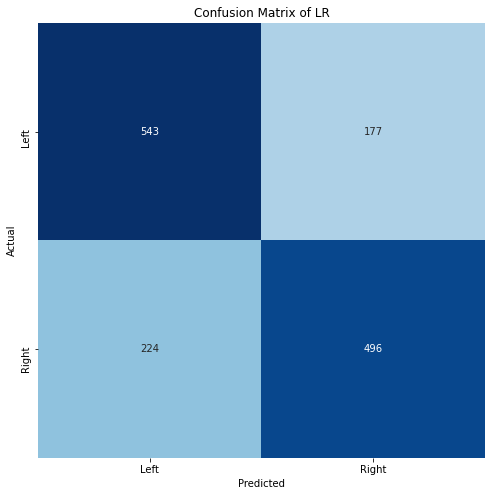

Classification Report of %s:
----------------------
 LR               precision    recall  f1-score   support

        Left       0.71      0.75      0.73       720
       Right       0.74      0.69      0.71       720

    accuracy                           0.72      1440
   macro avg       0.72      0.72      0.72      1440
weighted avg       0.72      0.72      0.72      1440



In [12]:
y_pred_LR = logistic_model.model.predict(x_test_data)
plot_confusion_matrix("LR", y_test, y_pred_LR)

### 2.2 Support Vector Machine

In [13]:
svm_model = gridsearchcv_model(sklearn.svm.SVC(), x_train_data, y_train, x_test_data, y_test)

SVC (train)
Accuracy: 0.9086
SVC (val)
Accuracy: 0.6958


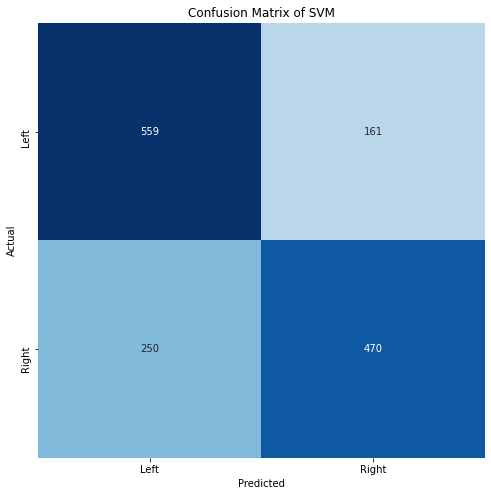

Classification Report of %s:
----------------------
 SVM               precision    recall  f1-score   support

        Left       0.69      0.78      0.73       720
       Right       0.74      0.65      0.70       720

    accuracy                           0.71      1440
   macro avg       0.72      0.71      0.71      1440
weighted avg       0.72      0.71      0.71      1440



In [14]:
y_pred_SVM = svm_model.model.predict(x_test_data)
plot_confusion_matrix("SVM", y_test, y_pred_SVM)

### 3.2 LDA

In [15]:
lda_model = gridsearchcv_model(sklearn.discriminant_analysis.LinearDiscriminantAnalysis(), x_train_data, y_train, x_test_data, y_test)

LinearDiscriminantAnalysis (train)
Accuracy: 0.9432
LinearDiscriminantAnalysis (val)
Accuracy: 0.6878


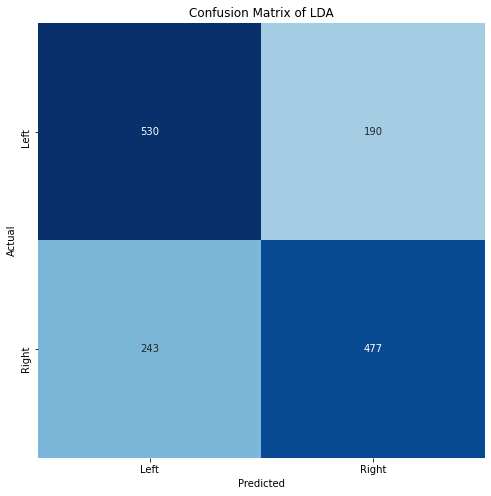

Classification Report of %s:
----------------------
 LDA               precision    recall  f1-score   support

        Left       0.69      0.74      0.71       720
       Right       0.72      0.66      0.69       720

    accuracy                           0.70      1440
   macro avg       0.70      0.70      0.70      1440
weighted avg       0.70      0.70      0.70      1440



In [16]:
y_pred_LDA = lda_model.model.predict(x_test_data)
plot_confusion_matrix("LDA", y_test, y_pred_LDA)

## 3. Deep Neural Network

### 3.1 LSTM model

In [17]:
inputs = tf.keras.Input(shape=(x_train_data.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(2, activation='softmax')(flatten)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 6000, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 6000, 256)         198912    
_________________________________________________________________
flatten (Flatten)            (None, 1536000)           0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3072002   
Total params: 3,270,914
Trainable params: 3,270,914
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train_data,
    y_train,
    validation_split=0,
    batch_size=32,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
140/140 [==============================] - 46s 313ms/step - loss: 7.8302 - accuracy: 0.6334
Epoch 2/50
140/140 [==============================] - 44s 313ms/step - loss: 0.4408 - accuracy: 0.8360
Epoch 3/50
140/140 [==============================] - 44s 314ms/step - loss: 0.1835 - accuracy: 0.9316
Epoch 4/50
140/140 [==============================] - 44s 313ms/step - loss: 0.0882 - accuracy: 0.9688
Epoch 5/50
140/140 [==============================] - 44s 313ms/step - loss: 0.0794 - accuracy: 0.9822
Epoch 6/50
140/140 [==============================] - 44s 312ms/step - loss: 0.7043 - accuracy: 0.8906
Epoch 7/50
140/140 [==============================] - 44s 313ms/step - loss: 0.3609 - accuracy: 0.9434
Epoch 8/50
140/140 [==============================] - 44s 315ms/step - loss: 0.2404 - accuracy: 0.9615
Epoch 9/50
140/140 [==============================] - 44s 315ms/step - loss: 0.0987 - accuracy: 0.9789
Epoch 10/50
140/140 [==============================] - 44s 314ms/step - l

In [19]:
model.evaluate(x_test_data, y_test)

45/45 [==============================] - 6s 121ms/step - loss: 19.0336 - accuracy: 0.7243


[19.033580780029297, 0.7243055701255798]

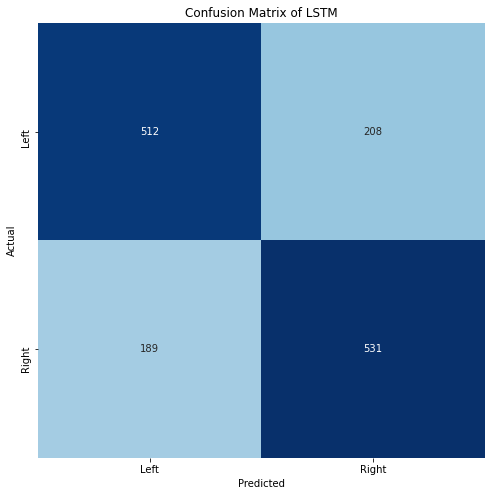

Classification Report of %s:
----------------------
 LSTM               precision    recall  f1-score   support

        Left       0.73      0.71      0.72       720
       Right       0.72      0.74      0.73       720

    accuracy                           0.72      1440
   macro avg       0.72      0.72      0.72      1440
weighted avg       0.72      0.72      0.72      1440



In [20]:
y_pred_LSTM = np.array(list(map(lambda x: np.argmax(x), model.predict(x_test_data))))
plot_confusion_matrix("LSTM", y_test, y_pred_LSTM)

### 3.2 Fully Connected

In [21]:
fc_network = keras.Sequential([Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001)),
                                   Dropout(0.2),
                                   Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001)),
                                   Dropout(0.2),
                                   Dense(1, activation="sigmoid")])

fc_network.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=["accuracy"])

In [22]:
history = fc_network.fit(x_train_data, y_train, epochs=50, batch_size=32)

Epoch 1/50
140/140 [==============================] - 1s 2ms/step - loss: 5.4411 - accuracy: 0.6183
Epoch 2/50
140/140 [==============================] - 0s 2ms/step - loss: 1.1184 - accuracy: 0.8094
Epoch 3/50
140/140 [==============================] - 0s 2ms/step - loss: 0.5787 - accuracy: 0.8964
Epoch 4/50
140/140 [==============================] - 0s 2ms/step - loss: 0.7797 - accuracy: 0.8883
Epoch 5/50
140/140 [==============================] - 0s 2ms/step - loss: 0.3860 - accuracy: 0.9431
Epoch 6/50
140/140 [==============================] - 0s 2ms/step - loss: 1.0904 - accuracy: 0.9501
Epoch 7/50
140/140 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.9471
Epoch 8/50
140/140 [==============================] - 0s 2ms/step - loss: 0.3001 - accuracy: 0.9622
Epoch 9/50
140/140 [==============================] - 0s 2ms/step - loss: 0.5577 - accuracy: 0.9443
Epoch 10/50
140/140 [==============================] - 0s 2ms/step - loss: 0.3901 - accuracy: 0.9511

In [23]:
print(fc_network.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (32, 512)                 3072512   
_________________________________________________________________
dropout (Dropout)            (32, 512)                 0         
_________________________________________________________________
dense_2 (Dense)              (32, 128)                 65664     
_________________________________________________________________
dropout_1 (Dropout)          (32, 128)                 0         
_________________________________________________________________
dense_3 (Dense)              (32, 1)                   129       
Total params: 3,138,305
Trainable params: 3,138,305
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
fc_network.evaluate(x_test_data, y_test)

45/45 [==============================] - 0s 2ms/step - loss: 3.6956 - accuracy: 0.7333


[3.6955556869506836, 0.7333333492279053]

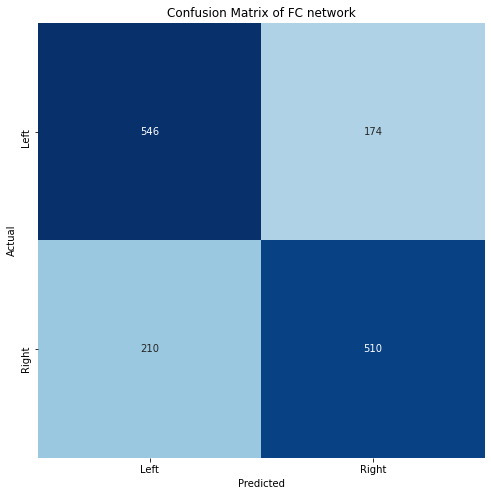

Classification Report of %s:
----------------------
 FC network               precision    recall  f1-score   support

        Left       0.72      0.76      0.74       720
       Right       0.75      0.71      0.73       720

    accuracy                           0.73      1440
   macro avg       0.73      0.73      0.73      1440
weighted avg       0.73      0.73      0.73      1440



In [25]:
y_pred_fc_network = np.array(list(map(lambda x: 1 if x > 0.5 else 0, fc_network.predict(x_test_data))))
plot_confusion_matrix("FC network", y_test, y_pred_fc_network)